# Surface-Wave Tomography

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/sw_tomography/sw_tomography.ipynb)

In this notebook, we will apply [CoFI](https://github.com/inlab-geo/cofi) to measurements of surface-wave velocity collected across the [USArray](http://www.usarray.org/) from the ambient seismic noise. Specifically, we will retrieve, through CoFI and [SeisLib](https://pypi.org/project/seislib/), a Rayleigh-wave phase velocity map of the Conterminous United States at the surface-wave period of 5 s. The employed velocity measurements belong to the data set compiled by [*Magrini et al. (2022)*](https://doi.org/10.1093/gji/ggac236).

> If you are running this notebook locally, make sure you've followed [these steps](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
> to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file specifies a list of packages required to run the notebooks)

## Theoretical Background

To map lateral variations in surface-wave velocity, SeisLib implements a least-squares inversion scheme based on ray theory. This method rests on the assumption that surface waves propagate, from a given point on the Earth’s surface to another, without deviating from the great-circle path connecting them. Under this assumption, the traveltime along the great-circle path can be written $t = \int_{\mathrm{path}}{s(\phi(l), \theta(l)) dl}$, 
where $\phi$ and $\theta$ denote longitude and latitude, and $s$ the sought Earth's slowness.

Let us consider a discrete parameterization of the Earth's surface, and assume each block 
(or grid cell) of such parameterization has constant slowness. The above integral expression 
can then be reformulated in the discrete form

$$
\label{eq:forward_problem}\tag{1}
s = \frac{1}{L} \sum_{n}{s_n l_n},
$$

where $L$ is the length of the great-circle path and $l$ the distance traveled by the surface wave through the $n$th block. Equation ($\ref{eq:forward_problem}$) represents the *forward* calculation that allows for retrieving the average velocity of propagation between two points on the Earth's surface (i.e., the quantity which is typically measured in ambient-noise seismology), provided that the (discrete) spatial variations in velocity (or slowness) are known.

If we now define the $m \times n$ matrix such that $A_{ij} = \frac{l_j}{L_i}$, where $L_i$ is the length of the great circle associated with $i$th observation, we can switch to matrix notation and write

$$
\label{eq:forward_matrix}\tag{2}
{\bf A \cdot x} = {\bf d},
$$

where $\bf d$ is an $m$-vector whose $k$th element corresponds to the measured slowness, and $\bf x$ the sought $n$-vector whose $k$th element corresponds to the model coefficient $s_k$. Matrix $\bf A$, also known as "data kernel" or "Jacobian", is computed numerically in a relatively simple fashion. For each pair of receivers for which a velocity measurement is available, its $i$th entries is found by calculating the fraction of great-circle path connecting them through each of the $n$ blocks associated with the parameterization.

In geophysical applications, the system of linear equations ($\ref{eq:forward_matrix}$) is usually ill-conditioned, meaning that it is not possible to find an exact solution for $\bf x$. (In our case, it is strongly overdetermined, i.e. $m \gg n$.) We overcome this issue by first assuming that the target slowness model is approximately known, i.e. ${\bf x}_0 \sim \bf{x}$. We then invert for the regularized least-squares solution

$$
\label{eq_inverse_prob}\tag{3}
{\bf x} = {\bf x}_0 + \left( {\bf A}^T \cdot {\bf A} + \mu^2 {\bf R}^T \cdot {\bf R} \right)^{-1} \cdot {\bf A}^T \cdot ({\bf d} - {\bf A} \cdot {\bf x}_0),
$$

where the roughness of the final model is determined by the scalar weight $\mu$ and the roughness operator $\bf R$ is dependent on the parameterization (for technical details on its computation, see [*Magrini et al. (2022)*](https://doi.org/10.1093/gji/ggac236)).

## 1. Data and Parameterization

As mentioned earlier, the [data](https://github.com/inlab-geo/cofi-examples/blob/main/examples/sw_tomography/data.txt) used in this notebook consist of inter-station measurements of Rayleigh-wave phase velocity at 5 s period. We parameterize the Earth's surface through equal-area blocks of $1^{\circ} \times 1^{\circ}$.

In [1]:
from seislib.tomography import SeismicTomography

tomo = SeismicTomography(cell_size=1) # Parameterization

# To reproduce the results locally, download data.txt and change the below path

tomo.add_data(src='./data.txt')

-------------------------------------
Optimal grid found in 91 iterations
-------------------------------------
-------------------------------------
GRID PARAMETERS
Lonmin - Lonmax : -180.000 - 180.000
Latmin - Latmax : -90.000 - 90.000
Number of cells : 41252
Grid cells of 1.000° : 41252
-------------------------------------


DATA PARAMETERS
Lonmin - Lonmax data : -124.566 - -67.312
Latmin - Latmax data : 24.727 - 49.098
Number of measurements : 171353
Source : ./data.txt
-------------------------------------



Overall, 171,353 velocity measurements are available (check `tomo.velocity`), each associated with a different pair of receveirs (check `tomo.data_coords`, consisting of a matrix of 171,353 rows and 4 columns: $\theta_1$, $\phi_1$, $\theta_2$, and $\phi_2$).

## 2. Jacobian

We use the information about the data coordinates to calculate the matrix $\bf A$ (i.e. the Jacobian). In doing so, we will discard all blocks parameterizing the Earth's surface that are not intersected by at least one inter-station great-circle path. These model parameters (referred to as "grid cells" in the below output) have no sensitivity to our data.

In [2]:
# This discards all blocks that are far away from the study area

tomo.grid.set_boundaries(latmin=tomo.latmin_data, 
                         latmax=tomo.latmax_data, 
                         lonmin=tomo.lonmin_data, 
                         lonmax=tomo.lonmax_data)

*** GRID UPDATED ***
-------------------------------------
GRID PARAMETERS
Lonmin - Lonmax : -125.774 - -65.926
Latmin - Latmax : 23.999 - 50.002
Number of cells : 1201
Grid cells of 1.000° : 1201
-------------------------------------


In [3]:
# Computes the coefficients of the A matrix, while discarding all model parameters that are not constrained by our data.
tomo.compile_coefficients(keep_empty_cells=False)

*** GRID UPDATED ***
-------------------------------------
GRID PARAMETERS
Lonmin - Lonmax : -125.774 - -66.537
Latmin - Latmax : 23.999 - 50.002
Number of cells : 775
Grid cells of 1.000° : 775
-------------------------------------


The Jacobian can now be accessed by typing `tomo.A`, and the associated parameterization can be visualized by typing

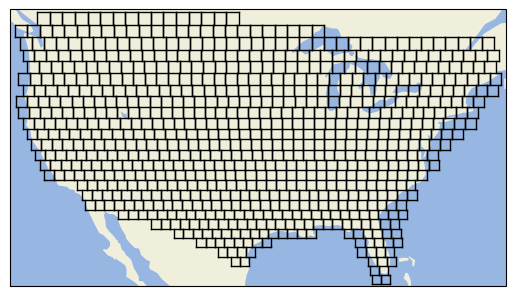

<GeoAxes: >

In [4]:
tomo.grid.plot()

## 3. Inversion -- SeisLib style

The lateral variations in phase velocity can now simply be retrieved, via SeisLib, through

In [5]:
mu = 5e-2 # Roughness damping coefficient, arbitrarily chosen

# The output of tomo.solve is slowness, hence we take the reciprocal

c = 1 / tomo.solve(rdamp=mu) # in km/s

Let's have a look at the results.

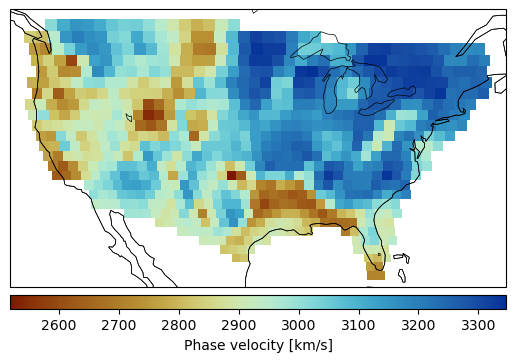

In [6]:
from seislib.plotting import plot_map
import seislib.colormaps as scm

img, cb = plot_map(tomo.grid.mesh, c, cmap=scm.roma, show=False)
cb.set_label('Phase velocity [km/s]')

## 4. Inversion -- CoFI style

Let's now reproduce the above results through CoFI. First, we need to define a starting model ${\bf x}_0$ to compute the residuals ${\bf r} = {\bf d} - {\bf A} \cdot {\bf x}_0$, as in equation (3).

In [7]:
import numpy as np

A = tomo.A # Jacobian
x0 = np.full(A.shape[1], 1 / tomo.refvel) # tomo.refvel is the average inter-station phase velocity
d = 1 / tomo.velocity # measurements of (average) inter-station slowness
r = d - A @ x0 # residuals

We now need to define the roughness operator $\bf R$. This is done under the hood by SeisLib through the "private" method `_derivatives_lat_lon`.

In [8]:
from seislib.tomography._ray_theory._tomography import _derivatives_lat_lon

# coordinates of each parameterization block, tomo.grid.mesh, should be in radians

R_lat, R_lon = _derivatives_lat_lon(np.radians(tomo.grid.mesh))
R = np.row_stack((R_lat, R_lon))

Almost everything is ready to carry out the inversion through CoFI. Before doing so, we need to define our inverse problem (through `BaseProblem`) and pass to it the data and the Jacobian (through `set_data` and `set_jacobian`). Finally, we will specify the regularizazion criterion (through `set_regularization`).

In [9]:
from cofi import BaseProblem
from cofi.utils import QuadraticReg

problem = BaseProblem()
problem.set_data(r) # our data are now the residuals defined above
problem.set_jacobian(A)

# As opposed to SeisLib, CoFI does not square the damping coefficient.
problem.set_regularization(mu**2 * QuadraticReg(R, (A.shape[1],)))   # L2 norm of R, i.e. R.T @ R

problem.summary()

Summary for inversion problem: BaseProblem
Model shape: Unknown
---------------------------------------------------------------------
List of functions/properties set by you:
['jacobian', 'regularization', 'data']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['jacobian_times_vector']
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['objective', 'log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian_times_vector', 'data_misfit', 'regularization_matrix', 'forward', 'data_covariance', 'data_covariance_inv', 'initial_model', 'model_shape', 'blobs_dtype', 'bounds', 'constraints']


We now carry out the inversion through `scipy.linalg.lstsq`.

In [10]:
from cofi import Inversion, InversionOptions

options = InversionOptions()
options.set_tool("scipy.linalg.lstsq")

inv = Inversion(problem, options)
inv_results = inv.run()
inv.summary()

Summary for Inversion
Completed with the following result:

Summary for inversion result
SUCCESS
model: [ 1.18179454e-06 -1.25177071e-05 -1.09358993e-05 -4.91566292e-06
  3.30435896e-06  5.65442303e-06  4.76237564e-06  8.81902823e-06
  1.08410009e-05  1.51420559e-05  2.25037965e-05  2.36951885e-05
  2.04676927e-05  1.50074366e-05  7.02904303e-06  5.04035200e-08
 -8.04395502e-08  3.98518542e-05  1.39452438e-05 -1.54276927e-05
 -1.49697038e-05 -8.59247577e-06 -1.36969843e-05  5.07935541e-06
  7.80266500e-06 -1.16544344e-05  4.66301865e-06  1.03449957e-05
  1.01949660e-05  1.90675486e-05  4.40184003e-05  4.34500804e-05
  8.43876299e-06 -3.07874077e-06 -2.18481778e-05 -2.57935726e-05
 -2.04246725e-05 -2.34561998e-05 -2.85126659e-05 -6.86848259e-06
 -3.66257498e-08  4.26711646e-05  6.04471855e-05  5.06158158e-06
 -4.78646988e-06 -1.25434180e-05 -1.24568555e-05 -9.42127235e-06
 -1.82659875e-06  5.55900889e-06 -1.46681175e-05 -4.53840079e-06
  8.30662686e-06  2.17424298e-05  3.14617201e-05  4

## 5. Cross validation

The inversion converged. Let's now check whether the results are consistent with those obtained from SeisLib. To do so, remember that we need to add back, to the retrieved model parameters, the initial reference model ${\bf x}_0$.

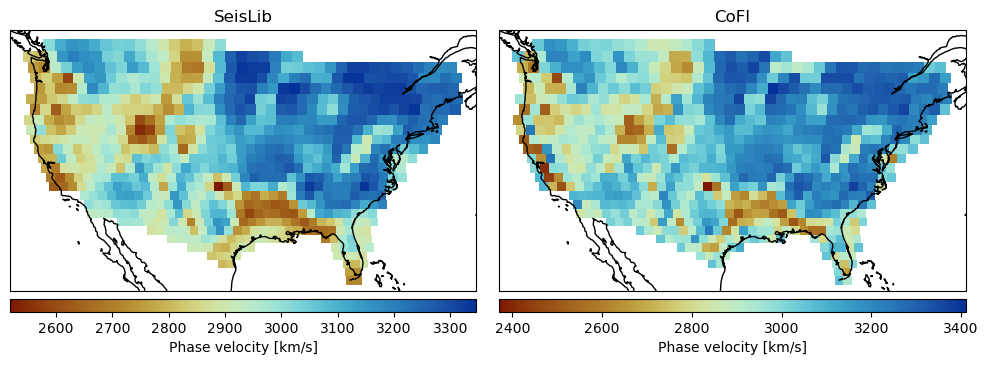

Are the results obtained from seislib and cofi the same? False


In [11]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# the reference model x0 is added back to get absolute values of slowness

c_cofi = 1 / ( inv_results.model + x0 )

fig = plt.figure(figsize=(10, 8))

# SeisLib map

ax1 = plt.subplot(121, projection=ccrs.Mercator())
ax1.coastlines()
img1, cb1 = plot_map(tomo.grid.mesh, c, ax=ax1, cmap=scm.roma, show=False)
cb1.set_label('Phase velocity [km/s]')
ax1.set_title('SeisLib')

# CoFI map

ax2 = plt.subplot(122, projection=ccrs.Mercator())
ax2.coastlines()
img2, cb2 = plot_map(tomo.grid.mesh, c_cofi, ax=ax2, cmap=scm.roma, show=False)
cb2.set_label('Phase velocity [km/s]')
ax2.set_title('CoFI')

plt.tight_layout()
plt.show()

print('Are the results obtained from seislib and cofi the same?', np.allclose(c, c_cofi))


## Watermark

In [12]:
libraries_used = ["cartopy", "cofi", "matplotlib", "numpy", "seislib"]
for lib in libraries_used:
    lib_var = __import__(lib)
    print(lib, getattr(lib_var, "__version__"))

cartopy 0.21.1
cofi 0.2.0
matplotlib 3.7.1
numpy 1.23.5
seislib 0.6.12
